### Importing Librabries and Data Cleaning

In [1]:
# Importing necessary libraries
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
from datasets import load_dataset
from adjustText import adjust_text
import seaborn as sns
import re
from datetime import datetime
import plotly.express as px
%matplotlib inline

# loading the dataset
health = pd.read_csv(r"C:\Users\DELL\Desktop\Regonet_project\healthcare_dataset.csv")

# Creating a copy of the dataset
health_1 = health.copy()

# Removing extra leading and trailing spaces from text-based columns
for col in health_1.select_dtypes(include='object'):
    health_1[col] = health_1[col].map(lambda x: re.sub(r'\s+', ' ', x).strip() if isinstance(x,str) else x)
    
# Converting the name coulmn to title case
health_1['Name'] = health_1['Name'].str.title()

# Renaming some columns to comply with python naming conventions
health_1.rename(columns={'Blood Type': 'Blood_Type','Medical Condition': 'Medical_Condition', 
                         'Date of Admission': 'Date_of_Admission', 'Insurance Provider': 'Insurance_Provider',
                         'Billing Amount': 'Billing_Amount','Room Number':'Room_Number',
                         'Admission Type':'Admission_Type', 'Discharge Date': 'Discharge_Date',
                         'Test Results':'Test_Results'
}, inplace=True)

# Converting the Date of Admission and Discharge Date to datetime format
health_1['Date_of_Admission'] = pd.to_datetime(health_1['Date_of_Admission'], errors='coerce').dt.strftime('%Y-%m-%d')
health_1['Discharge_Date'] = pd.to_datetime(health_1['Discharge_Date'], errors='coerce').dt.strftime('%Y-%m-%d')

# cleaning the Hospital column by removing commas and extra spaces
health_1['Hospital'] = (
    health_1['Hospital']
    .str.replace(',', '', regex=False) 
    .str.strip()                         
)

# Converting billing amount coulmn to 2 decimal palces
health_1['Billing_Amount'] = health_1['Billing_Amount'].round(2)

# checking dataet after cleaning
health_1.sample(10, random_state=42)

,Name,Age,Gender,Blood_Type,Medical_Condition,Date_of_Admission,Doctor,Hospital,Insurance_Provider,Billing_Amount,Room_Number,Admission_Type,Discharge_Date,Medication,Test_Results
31641,Michael Thornton Md,57,Male,O+,Diabetes,2023-09-15,Jason Hanson,Thornton-Roy,Medicare,3616.90,339,Elective,2023-10-02,Aspirin,Inconclusive
9246,Matthew Hutchinson,51,Female,A+,Diabetes,2023-10-07,Jesse Gonzalez,Wilkerson-Lewis,Aetna,36970.08,372,Emergency,2023-10-14,Penicillin,Abnormal
1583,Ronald Park,20,Male,A+,Asthma,2019-09-09,Sarah Hernandez,Brown-Hughes,Blue Cross,44393.00,148,Elective,2019-10-08,Penicillin,Inconclusive
36506,Jeff Brooks,74,Female,B+,Obesity,2020-09-14,Cathy Sanchez,Wilson Alexander Wolf and,Aetna,27554.92,135,Emergency,2020-09-21,Ibuprofen,Abnormal
11259,Tanya Thompson,56,Male,AB-,Obesity,2023-02-01,Nancy Lee,Winters Blackburn Chandler and,Aetna,27466.32,284,Emergency,2023-02-07,Paracetamol,Inconclusive
8972,Ethan Mitchell,46,Male,B+,Cancer,2021-12-30,Christina Hart,Rocha-Wagner,Medicare,4802.62,175,Elective,2022-01-27,Paracetamol,Abnormal
36078,Amber Wright,44,Female,O+,Asthma,2023-05-13,Melissa Stephens,Friedman-Douglas,Blue Cross,40207.46,336,Elective,2023-06-09,Paracetamol,Inconclusive
42659,Morgan Lawrence,46,Male,B-,Diabetes,2023-06-20,Paul Hansen,Wells and Davila Cooper,Medicare,30065.26,212,Elective,2023-07-16,Ibuprofen,Abnormal
6545,Mackenzie Maxwell,64,Female,AB-,Arthritis,2019-08-03,Thomas Pratt,and Alvarez Cox Powers,Cigna,392.91,113,Urgent,2019-08-15,Ibuprofen,Inconclusive
35448,Cindy Rogers,68,Male,B-,Cancer,2022-03-15,Calvin George,Conley Jackson and Hill,Medicare,20886.34,274,Urgent,2022-04-14,Penicillin,Normal


### Accessing Ward Capacity Utilization Rate

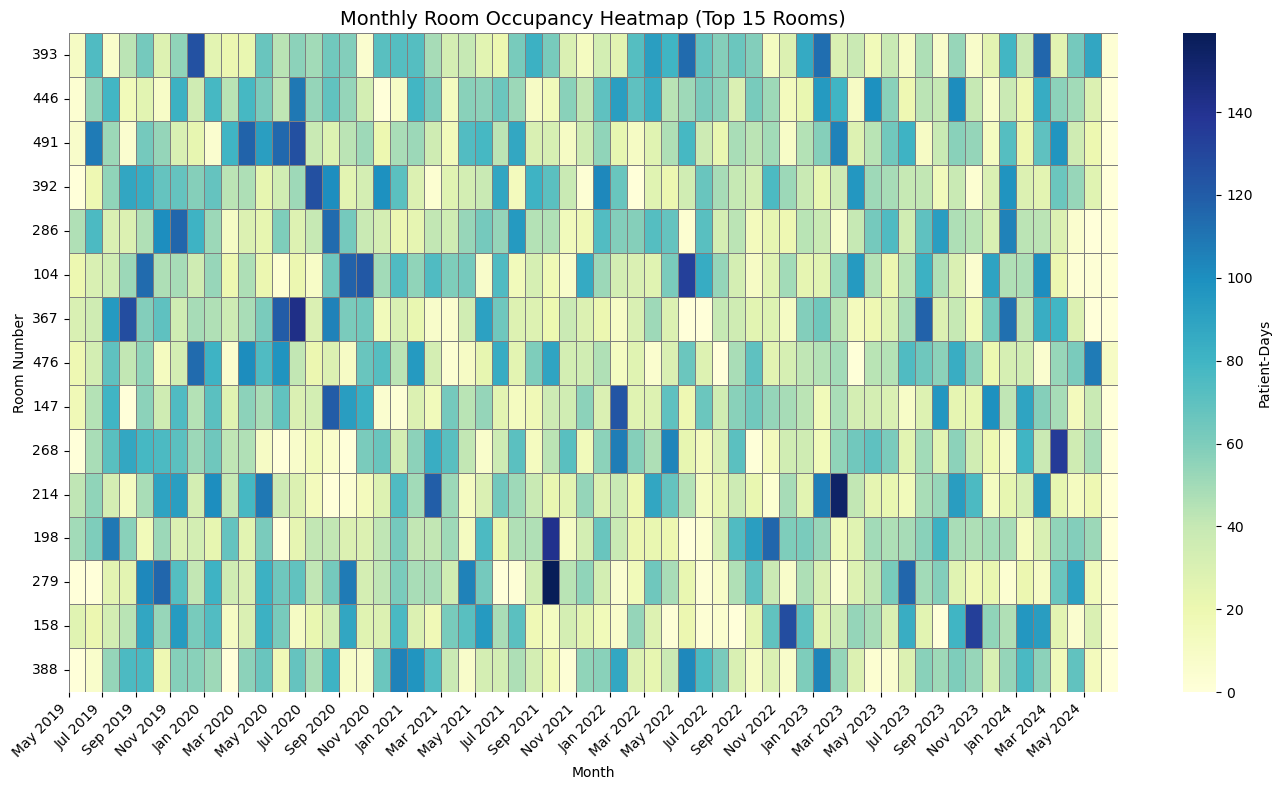

In [3]:
# Ensuring datetime datatypes
health_1['Date_of_Admission'] = pd.to_datetime(health_1['Date_of_Admission'], errors='coerce')
health_1['Discharge_Date'] = pd.to_datetime(health_1['Discharge_Date'], errors='coerce')

# Expanding into daily occupancy logs
room_stays = []
for _, row in health_1.iterrows():
    for day in pd.date_range(row['Date_of_Admission'], row['Discharge_Date']):
        room_stays.append({'Room_Number': str(row['Room_Number']), 'Date': day})

occupancy_df = pd.DataFrame(room_stays)

# Aggregating by Months
occupancy_df['Month'] = occupancy_df['Date'].dt.to_period('M').dt.to_timestamp()

# Creating pivot table
pivot_df = (
    occupancy_df.groupby(['Room_Number', 'Month'])
    .size()
    .unstack(fill_value=0)
)

# Keeping only top 15 busiest rooms
top_rooms = pivot_df.sum(axis=1).sort_values(ascending=False).head(15).index
pivot_df = pivot_df.loc[top_rooms]

# Plotting heatmap with month-based date axis
plt.figure(figsize=(14, 8))
ax = sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.4, linecolor='gray', cbar_kws={'label': 'Patient-Days'})

# Customizing x-tick labels (Month-Year)
dates = pivot_df.columns.to_list()
formatted_labels = [d.strftime('%b %Y') for d in dates]

# Reducing clutter by showing every 1–2 months
skip = 1 if len(formatted_labels) <= 10 else 2
selected_locs = list(range(0, len(dates), skip))
selected_labels = [formatted_labels[i] for i in selected_locs]

ax.set_xticks(selected_locs)
ax.set_xticklabels(selected_labels, rotation=45, ha='right')

plt.title("Monthly Room Occupancy Heatmap (Top 15 Rooms)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Room Number")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()